 <h1><center>Cibiobacter Cas9 exploratory analyses. 30/07/2019 update</center></h1>


##  Cas9 Mining Example: cibiobacter


<div style="text-align: right">Lorenzo federico Signorini, 16/07/2019</div>

<div style="text-align: right">Università degli studi di Trento</div>


In [1]:
# First created Thu Jul 11 09:51:15 CEST 2019
# Made by L-F-S
# At the University Of Trento, Italy

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO



sys.path.insert(0, '/home/lorenzo.signorini/utils/')
import filename_discrepancies


dataset="ZellerG_2014" #sys.argv[1] #TODO switch test dataset
tabledir="/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/3tabellazza" 
CRISPRdir="/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/1crisprsearch/out"
annodir="/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/2casanno/crisprcasanno"


# Cas9 Mining Example: _cibiobacter_

Extracting sequence information from one _cibiobacter_ genome
_cibiobacter_ is the SGB 15286

SGB (Species-level Genome Bin) is the taxonomical identification index for the genomes in the metagenomes dataset.
_Cibiobacter_ is a collection of more than a thousand genomes, all belonging to the same SGB, but with no reference in litterature, and no taxonomical identification beyond the family level. If one of these genomes carry a Cas9, it is definitiely going to be a new one.

Each genome is split into different _contigs_ , that are, separated contiguous chunks of DNA.


##  Looking for Cas9 inside _cibiobacter_ genomes

Let's see if _cibiobacter_ has a Cas9 gene.

In [3]:
datadir="/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/"
# Extract sequence information from GENOMES WITH <cas9> annotation.
feature="Cas9"
tabellazza=pd.read_csv(datadir+"/3tabellazza/crisprcas_hits_table.csv", index_col=0)

# OPTIONAL TODO : subsample for a single SGB
chosen_SGB=15286  # Cibiobacter SGB
single_SGB=tabellazza[tabellazza["SGB ID"]==chosen_SGB]
subset_of_genomes=single_SGB 
genomes_with_that_feature=subset_of_genomes[subset_of_genomes.prokka_cas.str.contains(feature)==True]

#genomes_with_that_feature=tabellazza[tabellazza.Study=="FerrettiP_2018"]
print("Found ", len(genomes_with_that_feature), " genomes with that feature.")



Found  23  genomes with that feature.


Great! some _cibiobacter_ have a cas9!
let's take a look at the first one:

### Just one genome

In [4]:
onegenome=genomes_with_that_feature.iloc[1,:]
onegenome

Unnamed: 0.1                                                        39928
Genome Name                                    HMP_2012__SRS015065__bin.2
Study                                                            HMP_2012
Sample Name                                                     SRS015065
Assembler                                                      metaSPAdes
Genome Size                                                       2265651
N50                                                                  6967
# Contigs                                                             406
Completeness                                                      91.8715
Contamination                                                     2.38095
Strain Heterogeneity                                             0.138982
SGB ID                                                              15286
pilercr_CRISPR          >NODE_3931_length_8539_cov_7.89097\tpilercr1.0...
minced_CRISPR           >NODE_3931_len

In [13]:
print(">"+onegenome.uniref_cas.split(">")[1])

>AJHGDLDC_00762 CRISPR-associated endoribonuclease Cas2|UniRef90_unknown|UniRef50_A0A0D8IWM6	MRMIVFFDLPVQTKTERRHATAFRNFLLKDGYHMLQFSVYARVCNGNDAVQKHESRLRASLPPNGSIRLLVVTEKQYQSIQILLGNYQPEEAPFVCEQLSFF	


In [8]:
cas9anno=onegenome.prokka_cas.lstrip(">").split(">")
CRISPRanno=onegenome.minced_CRISPR.lstrip(">").split(">")
#cas9anno.pop(0)
print("\n-----------------------------------------------------\nGenome Name:\t",onegenome["Genome Name"],"\n-----------------------------------------------------\n")
print("Cas proteins:")
[print(x.split("\t")[0], x.split("\t")[3],x.split("\t")[4], x[x.index("Name")+5:x.index("Name")+11])  for x in cas9anno]
print("\nCRISPR arrays: ")
[print(x.split("\t")[0], x.split("\t")[3],x.split("\t")[4], x) for x in CRISPRanno]



-----------------------------------------------------
Genome Name:	 HMP_2012__SRS015065__bin.2 
-----------------------------------------------------

Cas proteins:
NODE_3931_length_8539_cov_7.89097 2362 2670 cas2_1
NODE_3931_length_8539_cov_7.89097 2675 3556 cas1_1
NODE_3931_length_8539_cov_7.89097 3560 6784 cas9;g
NODE_5216_length_6484_cov_9.08866 2766 3410 cas5d;
NODE_15667_length_2205_cov_6.52419 294 584 cas2_2
NODE_15667_length_2205_cov_6.52419 594 1625 cas1_2

CRISPR arrays: 
NODE_3931_length_8539_cov_7.89097 1618 2313 NODE_3931_length_8539_cov_7.89097	minced:0.4.0	repeat_region	1618	2313	11	.	.	ID=CRISPR1;rpt_type=direct;rpt_family=CRISPR;rpt_unit_seq=GTCATAGTTCCCTAATAGCTCTTGGTATGGTATAAT


[None]

We have discovered a cas9 on the same contig (NODE_3931) of a cas1 and of a CRISPR array! there is probably an active CRISPR/cas system in this genome!!

## Print position of cas locus on contig in a pretty way

In [8]:
#1. count contigs:
#onegenome.prokka_cas.lstrip(">").split(">"
list_of_annotations=onegenome.minced_CRISPR.lstrip(">").split(">") + onegenome.prokka_cas.lstrip(">").split(">")
contigs=np.unique([anno.split("\t")[0] for anno in list_of_annotations])

anno_on_contig={}
for contig in contigs:
    anno_on_contig[contig] = [(x.split("\t")[3], x.split("\t")[4], x[x.index("Name")+5:x.index("Name")+11]) for x in cas9anno if contig == x.split("\t")[0]] 
    anno_on_contig[contig] += [(x.split("\t")[3],x.split("\t")[4],x[x.index("ID")+3:x.index("ID")+10]) for x in CRISPRanno]  
for contig in anno_on_contig.keys():
    print("\n-----------------------------------------------------\nContig:\t",
          contig,"\n-----------------------------------------------------")
    length=int(contig.split("_")[3])
    for anno in anno_on_contig[contig]:
        print(anno[2], "start:", int(anno[0]), "stop:", int(anno[1]))
       


-----------------------------------------------------
Contig:	 NODE_15667_length_2205_cov_6.52419 
-----------------------------------------------------
cas2_2 start: 294 stop: 584
cas1_2 start: 594 stop: 1625
CRISPR1 start: 1618 stop: 2313

-----------------------------------------------------
Contig:	 NODE_3931_length_8539_cov_7.89097 
-----------------------------------------------------
cas2_1 start: 2362 stop: 2670
cas1_1 start: 2675 stop: 3556
cas9;g start: 3560 stop: 6784
CRISPR1 start: 1618 stop: 2313

-----------------------------------------------------
Contig:	 NODE_5216_length_6484_cov_9.08866 
-----------------------------------------------------
cas5d; start: 2766 stop: 3410
CRISPR1 start: 1618 stop: 2313


## retrieving the sequence

In [9]:
dataset=onegenome.Study
genomename=onegenome["Genome Name"]#TODO!! Be careful for filename discrepancies ,e specially with ZeeviD files and with _megahit_ underscores!

path="/scratchCM/tmp_projects/epasolli_darkmatter/allcontigs/"+dataset+"/metabat/genomes_comp50_cont05/prokka/"+genomename    
filename=path+"/"+genomename+".faa"
cas9=[]
for record in SeqIO.parse(filename, "fasta"):
    if "Cas9" in record.description:
        cas9.append(record.seq)
len(cas9)

1

## Cas9 Sequence from one _cibiobacter_ genome:


In [10]:
print(cas9[0])

MKHPYGIGLDIGIASVGWAVVALNENAEPYGLIRCGSRIFDKAEQPKTGDSLAAPRREARSARRRLRRRSLRKADLYELMEKNGLPGKAEIEQAVQAGHLPDVYALRVQALDGPVTALDFARILLHLMQRRGFRSNRKADDAQKDGKLLQAIDANTRRMEANRYRTVGEMMYRDPVFAEHKRNKAENYLSTVKRDQIIDEVRLVFAAQRQYGATWASPEMEAEYLCILTRQRSFAEGPGKGSPYSGSNRVGTCTLEGKSEQRAAKAAFSFEYFTLLQKINHIRIAENGTSRTLTPAERQILLSVCCQTDKMDFARVRKALALPEEARFNMVRYRGEQTAEACEKKEKITALPCYHKMRKALNTLRKDHIRNISREQLDAAGAALTNPENEDKLREALKQAEFEPLEIEALLTLPSFAGYGHISVKACRKLIPYLEQGMNYNDACQAAGYDFQGRQNGEKAQFLPASTEEMDDITSPVVRRAVAQTIKVVNAIIREQGESPVSIHLELAREMNKNFQQRSELDKAMRDNSAENERLMKELNELFPGRTVTGQDLVKYRLWKEQNEICAYSLEKLDLTRVITEAGYAEVDHIVPYSISFDDRRTNKVLVLASENRQKGNRLPLQYLQGKRRDDFIVYTKANVKNFRKRQNLLKERLSEEDGKGYIQRNLQDTQYIAAFMLNYIRNHLAFADCSGAGKRRVVAVNGAVTAFLRKRWGLSKVRTDGDLHHAADAAVIACTTQGMIKRVSDFCKRAETTAVRNEHFPEPWPRFRDELTQRLSACPQEDLMKINPVYYATVDISSIQPVFVSRMPRHKVTGAAHEETIRSQVNEKYTAVRKSITELSLDKDGKIKDYFKPSSDTLLYEALKKRLTEFGGNAKKAFAEPFYKPRADGTPGAQVRKVKVVAKMNNTIPVRSGGGVAKGGDMIRIDVYYVPGDGYYWVPIYVADTVKETLPNKAVVRDKTMEEWKEMKEDDFLFSLYSNDLILVERDKPICFSLMHEDS

##  Extracting Cas9 for all the 23 _cibiobacter_ genomes and alligning them to get a _cibiobacter_ cas9 consensus sequence

In [57]:

for index, genome in genomes_with_that_feature.iterrows():
    print("\n-----------------------------------------------------\nGenome Name:\t",genome["Genome Name"],"\n-----------------------------------------------------")
    #print("Cas proteins:")
    featureanno=genome.prokka_cas.lstrip(">").split(">")
    #print(len(featureanno))
    if not type(genome.minced_CRISPR)==float:
        CRISPRanno=genome.minced_CRISPR.lstrip(">").split(">")  
    else:
#        print("*******************************************************************")
 #       if not type(genome.pilercr_CRISPR)==float:
  #          CRISPRanno=genome.pilercr_CRISPR.lstrip(">").split(">")
   #     else:
        CRISPRanno=[]
    list_of_annotations=featureanno + CRISPRanno 
    contigs=np.unique([anno.split("\t")[0] for anno in list_of_annotations])    
    anno_on_contig={}
    for contig in contigs:
        anno_on_contig[contig] = [(x.split("\t")[3], x.split("\t")[4], x[x.index("Name")+5:x.index("Name")+11]) for x in featureanno if contig == x.split("\t")[0]] 
        anno_on_contig[contig] += [(x.split("\t")[3],x.split("\t")[4],x.split("\t")[8][x.split("\t")[8].index("ID")+3:x.split("\t")[8].index("ID")+10]) for x in CRISPRanno if contig == x.split("\t")[0]]  
    for contig in anno_on_contig.keys():
        print("\t---------------------------------------------\n\tContig:\t",
              contig,"\n\t---------------------------------------------")
        length=int(contig.split("_")[3])
        for anno in anno_on_contig[contig]:
            print("\t",anno[2], "start:", int(anno[0]), "stop:", int(anno[1]))


-----------------------------------------------------
Genome Name:	 CM_madagascar__A01_02_1FE__bin.15 
-----------------------------------------------------
	---------------------------------------------
	Contig:	 NODE_1857_length_8093_cov_36.8492 
	---------------------------------------------
	 cas2;g start: 2905 stop: 3213
	 cas1;g start: 3218 stop: 4099
	 cas9;g start: 4103 stop: 7327
	 CRISPR1 start: 1695 stop: 2856

-----------------------------------------------------
Genome Name:	 HMP_2012__SRS015065__bin.2 
-----------------------------------------------------
	---------------------------------------------
	Contig:	 NODE_15667_length_2205_cov_6.52419 
	---------------------------------------------
	 cas2_2 start: 294 stop: 584
	 cas1_2 start: 594 stop: 1625
	---------------------------------------------
	Contig:	 NODE_3931_length_8539_cov_7.89097 
	---------------------------------------------
	 cas2_1 start: 2362 stop: 2670
	 cas1_1 start: 2675 stop: 3556
	 cas9;g start: 356

### Print all the 23 Cas9 Sequences in all the _cibiobacter_ genomes

In [13]:
cas9s={}
for index, genome in genomes_with_that_feature.iterrows():
    dataset=genome.Study
    genomename=genome["Genome Name"] #TODO Be careful for filename discrepancies, especially with ZeeviD files and with _megahit_ underscores!
    print("\n-----------------------------------------------------\nGenome Name:\t",genome["Genome Name"],"\n-----------------------------------------------------\n")

    
    ######################################################################
    # take into account filename discrepancies
    if dataset.startswith("ZeeviD"):
                   
             genomename=filename_discrepancies.change_to_megahit(genomename)
             try:
                 genomename=genomename.replace("ZeeviD_2015", "ZeeviD_2015_B")
                 prokkafile_ofsample=open(annodir+"/justminced/ZeeviD_2015_B/"+genomename+".crisprcas.gff.minced")
                 prokkafile_ofsample.close()
                 dataset="ZeeviD_2015_B"
             except:
                 genomename=genomename.replace("ZeeviD_2015_B", "ZeeviD_2015_A")
                 dataset="ZeeviD_2015_A"
    if filename_discrepancies.dataset_has_megahit(dataset,genomename):
        genomename=filename_discrepancies.change_to_megahit(genomename)
    ########################################################################

    path="/scratchCM/tmp_projects/epasolli_darkmatter/allcontigs/"+dataset+"/metabat/genomes_comp50_cont05/prokka/"+genomename    
    filename=path+"/"+genomename+".faa"
 
    for record in SeqIO.parse(filename, "fasta"):
        if "Cas9" in record.description:
            cas9s[record.id]=(dataset,genomename, record.seq, 
            print(record.seq,"\n", record.id)
    
    mincedCRISPRfilename=CRISPRdir+"/"+dataset+"/"+genomename+".fa.minced.out"
    f=open(mincedCRISPRfilename, "r")
    for line in f.readlines():
        print(line)
    f.close()
    
    #funge con DavidLa ma non combengtsonpalmerrrr


-----------------------------------------------------
Genome Name:	 CM_madagascar__A01_02_1FE__bin.15 
-----------------------------------------------------

ue
CM_madagascar__A01_02_1FE__bin.15
MKHPYGIGLDIGIASVGWAVVALNENAEPYGLIRCGSRIFDKAEEPQTGDSLAAPRRKARSARRRLRRRSLRKADLYELMEKNGLPGKAEIEQAVQAGHLPDVYALRVQALDGPVTALDFARILLHLMQRRGFRSNRKADDAQKDGKLLQAIDANTRRMEANRYRTVGEMMYRDPVFAEHKRNKAENYLSTVKRDQIIDEARLVFAAQRQYGATWASPEMEAEYLCILTRQRSFAEGPGKGSPYSGSNRVGTCTLEGKSEQRAAKAAFSFEYFTLLQKVNHIRIAENGTSRTLTPAERQVLLSVCSQTDKLDFARVRKALALPEEARFNMVRYRGEQTAEACEKKEKITALPCYHKMRKALNTLRKDHIRNISREQLDAAGAALTNPENEDKMREALKQAEFEPLEIEALLTLPSFAGYGHISVKACRKLIPYLEQGMNYNDACQAAGYDFQGRQNGEKAQFLPASTEEMEDITSPVVRRAVAQTIKVVNAIIREQGESPVSIHLELAREMNKNFQQRSELDKAMRDNSAENEKLMQELHAKFSGRKISGQDLVKYRLWKEQNEICAYSLEKLDLTQVITEPGYAEVDHIVPYSISFDDRRTNKVLVLKSENRQKGTRLPLQYLQGKRRDDFIVYTKANVKNFRKRQNLLKERLSEEDGKGYIQRNLQDTQYIAAFMLNYIRNHLAFADCSGAGKRRVVAVNGAVTAFLRKRWGLSKVRADGDLHHAADAAVIACTTQGMIKRVSDFCKRAETTAVRNEHFPEPWPHFRDELTQRLSACPQEDLMKINPVYYATVDISSIQPVF

MEKNGLPGKAEIEQAVQAGHLPDVYALRVQALDGPVTALDFARILLHLMQRRGFRSNRKADDAQKDGKLLQAIDANTRRMEANRYRTVGEMMYRDPVFAEHKRNKAENYLSTVKRDQIIDEARLVFAAQRQYGATWASPEMEAEYLCILTRQRSFAEGPGKGSPYSGSNRVGTCTLEGKSEQRAAKAAFSFEYFTLLQKINHIRIAKNGTSRTLTPAERQVLLSVCCQTDKLDFARIRKALALPEEARFNMVRYRGEQTAEACEKKEKITALPCYHKMRKALNTLRKDHIRNISREQLDAAGAALTNPENEDKLREALKQAEFEPLEIEALLTLPSFAGYGHISVKACRKLIPYLEQGMNYNDACQAAGYDFQGRQNGEKTKFLPASTEEMEDITSPVVRRAVAQTIKVVNAIIREQGESPVSIHLELAREMNKNFQQRSELDKAMRDNSAENERLMKELNELFPGRTVTGQDLVKYRLWKEQDGRCAYSIQPLELDKVITVSGYAEVDHIVPYSISFDDRRTNKVLVLASENRQKGNRLPLQYLQGKRRDDFIVYTKANVKNFRKRQNLLKERLSEEDGKGYIQRNLQDTQYIAAFMLNYIRNHLAFADCSGAGKRRVVAVNGAVTAFLRKRWGLSKVRADGDLHHAADAAVIACTTQGMIKRVSDFCKRAETTAVRNEHFPEPWPHFRDELRQRLSACPQEDLMKINPVYYATVDISSIQPVFVSRMPRHKVTGAAHEETIRSQVNEKYTAVRKSITELSLDKDGKIKDYFKPSSDTLLYEALKKRLTEFGGNAKKAFAEPFYKPRADGTPGAQVRKVKVVAKMNNTIPVRSGGGVAKGGDMIRIDVYYVPGDSYYWVPIYVADTVKETLPNKAVVRDKTMEEWKEMKEDDFLFSLYSNDLILVERDKPICFSLMHEDSTLPKKYETKKELVYYKGGDISNGGIRIETHEGAYFLKSLTFGIVQKVQKYQVDVLGNYTPVKKEKRQTFPAQRR 
 GO

MEKNGLPGKAEIEQAVQAGHLPDVYALRVQALDGPVTALDFARILLHLMQRRGFRSNRKADDAQKDGKLLQAIDANTRRMEANRYRTVGEMMYRDPVFAEHKRNKAENYLSTVKRDQIIDEARLVFAAQRQYGATWASPEMEAEYLCILTRQRSFAEGPGKGSPYSGSNRVGTCTLEGKSEQRAAKAAFSFEYFTLLQKINHIRIAENGTSRTLTPAERQVLLSVCSQTDKLDFARIRKALALPEEARFNMVRYRGEQTAEACEKKEKITALPCYHKMRKALNTLRKDHIRNISREQLDAAGAALTNPENEDKLREALEQAEFEPLEIEALLTLPSFAGYGHISVKACRKLIPYLEQGMNYNDACQAAGYDFQGRQNGEKAQFLPASTEEMEDITSPVVRRAVAQTIKVVNAIIREQGESPVSIHLELAREMNKNFQQRSELDKAMRDNSAENERLMKELNELFPGRTVTGQDLVKYRLWKEQDGRCAYSIQPLELDKVITVSGYAEVDHIVPYSISFDDRRTNKVLVLASENRQKGNRLPLQYLQGKRRDDFIVYTKANVKNFRKRQNLLKERLSEEDGKGYIQRNLQDTQYIAAFMLNYIRNHLAFADCSGAGKRRVVAVNGAVTAFLRKRWGLSKVRADGDLHHAVDAAVIACTTQGMIKRVSDFCKRAETTAVRNEHFPEPWPHFRDELTQRLSACPQEDLMKINPVYYATVDISSIQPVFVSRMPRHKVTGAAHKETIKSRLDDTHVVQRRNITELKLDKDGEIAGYFNRSSDTLLYNALKARLLAFGGDGKEAFAEPFYKPRADGTPGARVQKVKICDKVTSTVPVHGGKGVADNDTMVRIDVYYVPGDGYYWIPVYVADTVKPELPSKAVVAYKSSAEWKEMKDEDFLFSLCQHDLVRIESKRLMKFKVQHRDSTLEKEMPVNKILAYFEGGDIATGAVTLTTHDDAYIATGLGFKTLQKVQKYQVDVLGNYTPVKKEKRQTFPAQRR 
 OA

MAQGVEGKVPDVGILQQSVVVILEGFLLKVASKLVGHYKAVVKVFVPCPLLTQYIASFMLNYIRGHLAFAAHPMAGKKRVIAVNGAVTSFLRKRWGIAKVRADGDLHHAVDAAVIACTTDGMIQRVSRFYQREELSHARGERFPEPWPRFRDELMQRLSSCPQENLLTINPVYYTTVDIAGIKPVFVSRMPRHKATGPAHKETIKGRLDDTYVTQRRSITDLKLNKDGEIDGYFNPSSDTLLYNALKDRLVAFGGNGKKAFAEPFFKPRADGTPGAQVRKVKLYSKVTSTVPVHGGNGVADNDTMVRVDVYYIPGDGYYWVPIYVADTVKPILPNCAFVRCKNSIIKKEMSEENFLFSLCKNDLVCIESKRPIKLKAANEDSTLEKELTVQRVLAYFEGGDISTGAVSVTTHDNAYIVRGLGFKTLQKIEKYQVDVLGNYTRVKKEKRQLFPAQRR 
 AKECGJOI_00542

-----------------------------------------------------
Genome Name:	 QinN_2014__LD-97__bin.57 
-----------------------------------------------------

ue
QinN_2014__LD-97__bin.57
MKHPYGIGLDIGIASVGWAVMALNENAEPYGLIRCGSHIFDKAEQPKTGESLAAPRREARSTRRRLRRRSLRKADLYELMAQNGLPGRAKIEEAVQAGHLPDIYALRVQALDGPVTAMDFARILLHLMQRRGFRSNRKADDAQKDGKLLQAIDANTRRMEENHYRTVGEMMYRDPVFAEHKRNKSENYLSTVRRDQIVEEAVQLFAAQRQYGAAWASPEMEAEYLTILTRQRSFDEGPGGNSPYGGNIVEKMVGTCTLEGQAEPRAAKATWSFEYFTLLQKINHIRIIESGAARILTAEERQELLSVCYQTDKLDFARIRKALALPEQARFNMVRYRDGQTTEDCEKK

MKHPYGIGLDIGIASVGWAVVVLNENAEPYGLIRCGSRIFDKAEQPKTGESLAAPRREARSTRRRLRRRSLRKADLYELMAQNGLPGRAKIEEAVQAGHLPDIYALRVQALDGPVTAMDFARILLHLMQRRGFRSNRKADDAQKDGKLLQAIDANTRRMKENHYRTVGEMMYRDPVFAEHKRNKSENYLSTVRRDQIVEEAVQLFAAQRQYGAAWASQEMEAEYLTILTRQRSFDEGPGGNSPYGGNIVEKMVGTCTLEGQAEPRAAKATWSFEYFTLLQKINHIRIIESGAARILTAEERQELLSVCYQTDKLDFARIRKALALSEQARFNMVRYRDGQTTEDCEKKEKIVCLPCYHKMRKVLNTLRKDYIRSVSRDRLDAAATALTMYKNEATLRAKLEEAQFEPLEVDALMTLPSFSGFGHISVKACRKLIPYLEQGLNYSDACKEAGYDFQGNYRGEKSQFLPASTEEMEDITSPVVRRAVAQTIKVVNAIIREQGESPVNIHLELAREMSKNFQQRNDLDKAMKDNNAENERLMKDLHELFPGRNITGQDLVKYRLWKEQDGRCAYSLQPLELEKTITVSGYAEVDHIVPYSISFDDRRANKVLVLASENRQKGNRLPLQYLQGKRRDDFIVYTKASVKNYRKRQNLLKEKLSEEDSKGFMQRNLQDTQYIASFMLNYIRSHLAFADFPAAGKKRVVAVNGAVTAFLRKRWGLGKVRADGDLHHAVDAAVIACTTDGMIQRVSRFYTHIETSDTRGERFPEPWPRFRDELMQRLSACPQENLMQINPVYYQNVDIASIRPVFVSRMPRHKMTGAAHKETIKGRLDDAHTVQRRSITDLKLDKEGEIAGYFNPSSDTLLYNALKEQLTAFGGDGKKAFAEPFFKPRADGTPGAQVRKVKVYDKATSMVAVHEGKGVADNDTMVRIDVYFVPGDGYYWVPIYVADTVKPELPNKAVVAYKNYDEWKEMDEENFLFSLCQNDLIRIESKRTMKFKVQN

MRKALNTLRKDHIRNISREQLDAAGAALTNPENEDKLREALKQAEFEPLEIEALLTLPSFAGYGHISVKACRKLIPYLEQGMNYNDACQAAGYDFQGRQNGEKAQFLPASTEEMEDITSPVVRRAVAQTIKVVNAIIREQGESPVSIHLELAREMNKNFQQRSELDKAMRDNSAENERLMKELNELFPGRTVTGQDLVKYRLWKEQDGRCAYSIQPLELDKVITVSGYAEVDHIVPYSISFDDRRTNKVLVLKSENRQKGNRLPLQYLQGKRRDDFIVYTKANVKNFRKRQNLLKERLSEEDGKGYIQRNLQDTQYIAAFMLNYIRNHLAFADCSGAGKRRVVAVNGAVTAFLRKRWGLSKVRADGDLHHAVDAAVIACTTQGMIKRVSDFCKRAETTAVRNEHFPEPWPHFRDELRQRLSACPQEDLMKINPVYYATVDISSIQPVFVSRMPCHKVTGAAHEETIRSQVDEQYTAVRKSITELSLDKDGKIKDYFNPSSDTLLYEALKKRLTEFGGNAKKAFAEPFYKPRADGTPGAQVRKVKVVAKMNNTIPVRSGGGVAKGGDMIRIDVYYVPGDGYYWVPIYVADTVKETLPNKAVVRDKTMEEWKEMKEDDFLFSLYSNDLILVERDKPICFSLMHEDSTLPKKYETKKELVYYKGGDISNGGIRIETHEGAYFLKSLTFGIVQKVQKYQVDVLGNYTPVKKEKRQTFPAQRR 
 MIAKMKKN_01463
Sequence 'NODE_15259_length_2007_cov_2.9124' (2007 bp)



CRISPR 1   Range: 54 - 223

POSITION	REPEAT				SPACER

--------	---------------------------------	-----------------------------------

54		ATTTCTATCCACGCTCTCCTTGCGGAGAGCGAC	ATCCTCCAACACAGGGCATGCCGTACAATACCT

FileNotFoundError: [Errno 2] No such file or directory: '/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/1crisprsearch/out/ZeeviD_2015_A/ZeeviD_2015_A__PNP_Main_170_megahit__bin.20.fa.minced.out'

### Additional info:

In [14]:
for key, sequence in cas9s.items():
    print("Seq. ID: ", key[2],"\tSeq. length", len(sequence), "Genome: ",key[0])

Seq. ID:  LJPIBCCN_01736 CRISPR-associated endonuclease Cas9 	Seq. length 1074 Genome:  CM_madagascar__A01_02_1FE__bin.15
Seq. ID:  AJHGDLDC_00764 CRISPR-associated endonuclease Cas9 	Seq. length 1074 Genome:  HMP_2012__SRS015065__bin.2
Seq. ID:  FNDJMBCE_00556 CRISPR-associated endonuclease Cas9 	Seq. length 1077 Genome:  HMP_2012__SRS063985__bin.20
Seq. ID:  GODHHABP_00381 CRISPR-associated endonuclease Cas9 	Seq. length 995 Genome:  LeChatelierE_2013__MH0170__bin.8
Seq. ID:  NFMBCDAL_01965 CRISPR-associated endonuclease Cas9 	Seq. length 1074 Genome:  LeChatelierE_2013__MH0229__bin.1
Seq. ID:  OENGOFOO_00948 CRISPR-associated endonuclease Cas9 	Seq. length 947 Genome:  LeChatelierE_2013__MH0253__bin.48
Seq. ID:  KBDPKFLH_01036 CRISPR-associated endonuclease Cas9 	Seq. length 1077 Genome:  LeChatelierE_2013__MH0452__bin.25
Seq. ID:  OADPKIBO_00772 CRISPR-associated endonuclease Cas9 	Seq. length 995 Genome:  LiJ_2014__O2.UC13-1__bin.49
Seq. ID:  NCCHGPDI_00805 CRISPR-associated endon

### ClustalW alignment:

Let's take a look at the sequences of 1074 aminoacids:


In [30]:
from Bio.Alphabet import generic_dna, generic_protein
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align.Applications import ClustalwCommandline
from Bio.Align import AlignInfo

In [16]:
alignments=[]
for key, sequence in cas9s.items():
    if len(sequence)==1074:  #3225nb
        tempseq=SeqRecord(sequence, id=key[1], description=key[2]+" from GENOME: "+key[0])
        alignments.append(tempseq)
        
SeqIO.write(alignments, "/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/extractcas/cibiobacter_example.faa", "fasta")


7

In [17]:

cline= ClustalwCommandline("clustalw", infile="/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/extractcas/s/cibiobacter_example.faa", outfile="/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/5extractcas/cibiobacter_example.faa.aln")
print(cline)


clustalw -infile=/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/extractcas/s/cibiobacter_example.faa -outfile=/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/5extractcas/cibiobacter_example.faa.aln


In [18]:
os.system(str(cline))

65280

In [19]:
align = AlignIO.read("/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/extractcas/cibiobacter_example.faa.aln", "clustal")
print(align)

SingleLetterAlphabet() alignment with 8 rows and 1074 columns
MKHPYGIGLDIGIASVGWAVVALNENAEPYGLIRCGSRIFDKAE...QRR LJPIBCCN_01736
MKHPYGIGLDIGIASVGWAVVALNENAEPYGLIRCGSRIFDKAE...QRR NEDPKBLJ_01253
MKHPYGIGLDIGIASVGWAVVALNENAEPYGLIRCGSRIFDKAE...QRR NFMBCDAL_01965
MKHPYGIGLDIGIASVGWAVVALNENAEPYGLIRCGSRIFDKAE...QRR IHGAOIHE_01452
MKHPYGIGLDIGIASVGWAVVALNENAEPYGLIRCGSRIFDKAE...QRR BJCNOPOP_01511
MKHPYGIGLDIGIASVGWAVVALNENAEPYGLIRCGSRIFDKAE...QRR COLPFJHK_01598
MKHPYGIGLDIGIASVGWAVVALNENAEPYGLIRCGSRIFDKAE...QRR AJHGDLDC_00764
MKHPYGIGLDIGIASVGWAVVALNENAEPYGLIRCGSRIFDKAE...QRR KHEFALFL_01204


## 2.5 Consensus sequence for _cibiobacter_ cas9

In [20]:
summary_align = AlignInfo.SummaryInfo(align)
CONSENSUS_SEQUENCE=SeqRecord(summary_align.dumb_consensus(0.5), id="PROVA", description="Cibiobacter Cas9 Consensus sequence")
filename="/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/extractcas/cibiobacter_cas9_consensus.faa" #ffn
SeqIO.write(CONSENSUS_SEQUENCE, filename, "fasta")

1

In [21]:
for record in SeqIO.parse(filename, "fasta"):
    con=record.seq
    print(record.seq)

MKHPYGIGLDIGIASVGWAVVALNENAEPYGLIRCGSRIFDKAEQPKTGDSLAAPRREARSARRRLRRRSLRKADLYELMEKNGLPGKAEIEQAVQAGHLPDVYALRVQALDGPVTALDFARILLHLMQRRGFRSNRKADDAQKDGKLLQAIDANTRRMEANRYRTVGEMMYRDPVFAEHKRNKAENYLSTVKRDQIIDEARLVFAAQRQYGATWASPEMEAEYLCILTRQRSFAEGPGKGSPYSGSNRVGTCTLEGKSEQRAAKAAFSFEYFTLLQKINHIRIAENGTSRTLTPAERQVLLSVCCQTDKLDFARVRKALALPEEARFNMVRYRGEQTAEACEKKEKITALPCYHKMRKALNTLRKDHIRNISREQLDAAGAALTNPENEDKLREALKQAEFEPLEIEALLTLPSFAGYGHISVKACRKLIPYLEQGMNYNDACQAAGYDFQGRQNGEKAQFLPASTEEMEDITSPVVRRAVAQTIKVVNAIIREQGESPVSIHLELAREMNKNFQQRSELDKAMRDNSAENERLMKELNELFPGRTVTGQDLVKYRLWKEQDGRCAYSIQPLELDKVITVSGYAEVDHIVPYSISFDDRRTNKVLVLASENRQKGNRLPLQYLQGKRRDDFIVYTKANVKNFRKRQNLLKERLSEEDGKGYIQRNLQDTQYIAAFMLNYIRNHLAFADCSGAGKRRVVAVNGAVTAFLRKRWGLSKVRADGDLHHAADAAVIACTTQGMIKRVSDFCKRAETTAVRNEHFPEPWPRFRDELTQRLSACPQEXLMXINPVYYATVDISSIQPVFVSRMPRHKVTGAAHKETIKSRLDDXHXVQRRXITELKLDKDGEIAGYFNXSSDTLLYNALKARLXAFGGDGKKAFAEPFYKPRADGTPGAXVXKVKXCDKVTSTVPVHGGKGVADNDTMVRIDVYFVPGDGYYWVPIYVADTVKLELPNKAVVQGKSYAEWKEMDEENFLFSLCQXDLXRIESKRLMKFKVQNRDS

In [22]:
len(con)

1074

## 2.6 Comparison between _cibiobacter_ and _Streptococcus pyogenes_ Cas9

In [23]:
from Bio import pairwise2
#for record in SeqIO.parse("/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/spyrcas9.txt", "fasta"):
 #   Cas9=SeqRecord(record.seq, id=record.id, description=record.description)
  #  break
Cas9="MDKKYSIGLDIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKNLIGALLFDSGETAEATRLKRTARRRYTRRKNRICYLQEIFSNEMAKVDDSFFHRLEESFLVEEDKKHERHPIFGNIVDEVAYHEKYPTIYHLRKKLVDSTDKADLRLIYLALAHMIKFRGHFLIEGDLNPDNSDVDKLFIQLVQTYNQLFEENPINASGVDAKAILSARLSKSRRLENLIAQLPGEKKNGLFGNLIALSLGLTPNFKSNFDLAEDAKLQLSKDTYDDDLDNLLAQIGDQYADLFLAAKNLSDAILLSDILRVNTEITKAPLSASMIKRYDEHHQDLTLLKALVRQQLPEKYKEIFFDQSKNGYAGYIDGGASQEEFYKFIKPILEKMDGTEELLVKLNREDLLRKQRTFDNGSIPHQIHLGELHAILRRQEDFYPFLKDNREKIEKILTFRIPYYVGPLARGNSRFAWMTRKSEETITPWNFEEVVDKGASAQSFIERMTNFDKNLPNEKVLPKHSLLYEYFTVYNELTKVKYVTEGMRKPAFLSGEQKKAIVDLLFKTNRKVTVKQLKEDYFKKIECFDSVEISGVEDRFNASLGTYHDLLKIIKDKDFLDNEENEDILEDIVLTLTLFEDREMIEERLKTYAHLFDDKVMKQLKRRRYTGWGRLSRKLINGIRDKQSGKTILDFLKSDGFANRNFMQLIHDDSLTFKEDIQKAQVSGQGDSLHEHIANLAGSPAIKKGILQTVKVVDELVKVMGRHKPENIVIEMARENQTTQKGQKNSRERMKRIEEGIKELGSQILKEHPVENTQLQNEKLYLYYLQNGRDMYVDQELDINRLSDYDVDHIVPQSFLKDDSIDNKVLTRSDKNRGKSDNVPSEEVVKKMKNYWRQLLNAKLITQRKFDNLTKAERGGLSELDKAGFIKRQLVETRQITKHVAQILDSRMNTKYDENDKLIREVKVITLKSKLVSDFRKDFQFYKVREINNYHHAHDAYLNAVVGTALIKKYPKLESEFVYGDYKVYDVRKMIAKSEQEIGKATAKYFFYSNIMNFFKTEITLANGEIRKRPLIETNGETGEIVWDKGRDFATVRKVLSMPQVNIVKKTEVQTGGFSKESILPKRNSDKLIARKKDWDPKKYGGFDSPTVAYSVLVVAKVEKGKSKKLKSVKELLGITIMERSSFEKNPIDFLEAKGYKEVKKDLIIKLPKYSLFELENGRKRMLASAGELQKGNELALPSKYVNFLYLASHYEKLKGSPEDNEQKQLFVEQHKHYLDEIIEQISEFSKRVILADANLDKVLSAYNKHRDKPIREQAENIIHLFTLTNLGAPAAFKYFDTTIDRKRYTSTKEVLDATLIHQSITGLYETRIDLSQLGGD"

alignments = pairwise2.align.globalxx(con, Cas9)

In [24]:
print(pairwise2.format_alignment(*alignments[0]))

M-KHP-YG-IGLDIGIA--SVGWAVVALNENA---EPYG---------LIRCGS---R--IFDKAEQPKT---G----DSLA---APRREA-RS----ARRRL--RR--RS---LRK--------A--D------LYE---LM-E--KNGLPGKA-E---I------EQAVQAG-HL---PDV--YA-LRVQA--LDGPV--TALDF-A--R-I-L-L-HLMQR---RG-FRS------NRKA-D--DAQK-DGKL---L-QA----------I-----DANT------R----RM--EANRYRTV------GEMMYRDPV-----F----AEHKR-------N-K-----AENY---L--STVKRD-----------QII-DE--AR-LVF-AAQRQYG-----A----------TW----ASPE----M-----E---------A-------E-YLC--ILTR---QRSF----AEGP---GKG-SP----YSGSNRVGTCT------LE---G------KS---EQ---RAAKAA---F---SF--------EYFTL---L--Q-------KI-NH---I------RI-------AEN-GT-SR----TL-----T--PA---ERQ-VLLSVCC------Q------T--DK-LDFAR----VR--KA--LALPE-EAR-FNM-VRYRG-EQ-TAEACEK-K---E---KIT-A-LPCYH----KMRKA---L----N---T---LRK-DH----IRN-------ISR--EQLDAAGA---A-L-T---------------NPE-NEDK-LREA---LKQAE----FEPL--E-IEAL--L-T---LPSFAG------------Y-GHI----SVKACRKLIPYLEQGMNYN---DAC-QAA-GY----DFQ----G---RQNGEKAQF--LPA----S-TEEM--EDITSPVVRR--A-VA--QT-------IKVV-N-A----I---IRE-QG--

In [25]:
alignments = pairwise2.align.globalxx(Cas9, Cas9)
print(pairwise2.format_alignment(*alignments[0]))

MDKKYSIGLDIGTNSVGWAVITDEYKVPSKKFKVLGNTDRHSIKKNLIGALLFDSGETAEATRLKRTARRRYTRRKNRICYLQEIFSNEMAKVDDSFFHRLEESFLVEEDKKHERHPIFGNIVDEVAYHEKYPTIYHLRKKLVDSTDKADLRLIYLALAHMIKFRGHFLIEGDLNPDNSDVDKLFIQLVQTYNQLFEENPINASGVDAKAILSARLSKSRRLENLIAQLPGEKKNGLFGNLIALSLGLTPNFKSNFDLAEDAKLQLSKDTYDDDLDNLLAQIGDQYADLFLAAKNLSDAILLSDILRVNTEITKAPLSASMIKRYDEHHQDLTLLKALVRQQLPEKYKEIFFDQSKNGYAGYIDGGASQEEFYKFIKPILEKMDGTEELLVKLNREDLLRKQRTFDNGSIPHQIHLGELHAILRRQEDFYPFLKDNREKIEKILTFRIPYYVGPLARGNSRFAWMTRKSEETITPWNFEEVVDKGASAQSFIERMTNFDKNLPNEKVLPKHSLLYEYFTVYNELTKVKYVTEGMRKPAFLSGEQKKAIVDLLFKTNRKVTVKQLKEDYFKKIECFDSVEISGVEDRFNASLGTYHDLLKIIKDKDFLDNEENEDILEDIVLTLTLFEDREMIEERLKTYAHLFDDKVMKQLKRRRYTGWGRLSRKLINGIRDKQSGKTILDFLKSDGFANRNFMQLIHDDSLTFKEDIQKAQVSGQGDSLHEHIANLAGSPAIKKGILQTVKVVDELVKVMGRHKPENIVIEMARENQTTQKGQKNSRERMKRIEEGIKELGSQILKEHPVENTQLQNEKLYLYYLQNGRDMYVDQELDINRLSDYDVDHIVPQSFLKDDSIDNKVLTRSDKNRGKSDNVPSEEVVKKMKNYWRQLLNAKLITQRKFDNLTKAERGGLSELDKAGFIKRQLVETRQITKHVAQILDSRMNTKYDENDKLIREVKVITLKSKLVSDFRKDFQFYKVREINNYHHAHDAYLNAVVGTALIKK

In [26]:
478/1368

0.34941520467836257

# Fishing for protospacers

In [9]:
    from Bio.Blast.Applications import NcbiblastnCommandline


In [64]:
for index, genome in genomes_with_that_feature.iterrows():
    dataset=genome.Study
    genomename=genome["Genome Name"] #TODO Be careful for filename discrepancies, especially with ZeeviD files and with _megahit_ underscores!
    print("\n-----------------------------------------------------\nGenome Name:\t",genome["Genome Name"],"\n-----------------------------------------------------\n")
   
    ######################################################################
    # take into account filename discrepancies
    if dataset.startswith("ZeeviD"):  #TODO guarda se funziona quando finisci di girare minced_runner
             s3_dataset="ZeeviD_2015"
             #genomename=filename_discrepancies.change_to_megahit(genomename)
             s3_genomename=genomename
             try:
                 genomename=genomename.replace("ZeeviD_2015", "ZeeviD_2015_B")
                 prokkafile_ofsample=open(annodir+"/justminced/ZeeviD_2015_B/"+genomename+".crisprcas.gff.minced")
                 prokkafile_ofsample.close()
                 dataset="ZeeviD_2015_B"
             except:
                 genomename=genomename.replace("ZeeviD_2015_B", "ZeeviD_2015_A")
                 dataset="ZeeviD_2015_A"
    else:
        s3_dataset=dataset
        s3_genomename=genomename
        dataset=filename_discrepancies.s3(s3_dataset,r=True) # get working dataset name from s3 dataset name
        genomename=genomename.replace(s3_dataset, dataset)
        
    #print(dataset)
    if filename_discrepancies.dataset_has_megahit(dataset,genomename):
        genomename=filename_discrepancies.change_to_megahit(genomename)
    ########################################################################

 #   path="/scratchCM/tmp_projects/epasolli_darkmatter/allcontigs/"+dataset+"/metabat/genomes_comp50_cont05/prokka/"+genomename    
  #  filename=path+"/"+genomename+".faa"
    #print("quindi siamo sicuri che genomename è ", genomename)
    #print(all_contigs_for_that_sample)
    # 1 get CRISPR spacer sequence
    spacers_list_of_contig={}
    mincedCRISPRfilename=CRISPRdir+"/"+s3_dataset+"/"+s3_genomename+".fa.minced.out"
    #print(mincedCRISPRfilename)
    f=open(mincedCRISPRfilename, "r")
    for line in f.readlines():
        if line.startswith("Sequence"):
            contig=line.split(" ")[1].strip("\'")
            spacers_list_of_contig[contig]=[]
        if line[0]== "1" or line[0]== "2" or line[0]== "3" or line[0]== "4" or line[0]== "5" or \
        line[0]== "6" or line[0]== "7" or line[0]== "8" or line[0]== "9" or line[0]== "0":
          #  print(line)
            if not line.split("\t")[3]=="\n":
                spacers_list_of_contig[contig].append(line.split("\t")[3])
    f.close()
   # print(spacers_list_of_contig)

# 2 BLAST against protospacer
    blast_folder="/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch"
    os.chdir(blast_folder+"/"+s3_dataset)
    all_contigs_for_that_sample="/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/"\
                +dataset+"/"+dataset+"__"+genome["Sample Name"]+".contigs_filtered.fasta"#TODO filename discrepancies?
# attenzione: da fare prima lo step intermedio: creare blastdb    
# ma ancora piu a monte: filtra i contigs perché abbiano solo i genomi non  filtrati lol
    
    #for record in SeqIo.parse(all_contigs_for_that_sample, "fasta")
# funziona tt anche i megahit i nomi tt , qll che voglio fare è blastare ogni sequenzina contro ogni contig for that sample (ma tenedo fuori il contig da cui proviene)
   # print(spacers_list_of_contig.items())
#help(NcbiblastxCommandline)

    for contig in spacers_list_of_contig.keys():
        tempfile=open("temp_spacer_seq", "w")
        tempfile.close()
        tempfile=open("temp_spacer_seq", "a")
        for n, spacer in enumerate(spacers_list_of_contig[contig]):
            
            tempfile.write(">spacer"+str(n+1)+"\n"+spacer+"\n")            
            blastoutpath=blast_folder+"/"+s3_dataset+"/"+genome["Genome Name"]+"_"+contig+".xml"
            blastn_cline = NcbiblastnCommandline(query=blast_folder+"/"+s3_dataset+"/temp_spacer_seq", db=all_contigs_for_that_sample, evalue=0.001,
                                     outfmt=5, out=blastoutpath, word_size=4)
              #          blastn_cline
            print(blastn_cline)
        tempfile.close()

           # lancia blast da fuori, poi qnd ha fatto  continua oppure os.system (str(blastn_cline) ) forse funge..

        # parse output
        result_handle=open(blastoutpath)
        blast_records = NCBIXML.parse(result_handle)

        for blast_record in blast_records:
            print(blast_record.descriptions[0])
            for alignment in blast_record.alignments:
                print("****Alignment****")
                for hsp in alignment.hsps:
                     if hsp.expect <0.04:

                         print("***hsp*****")
                         print("sequence:", alignment.title)
                         print("length:", alignment.length)
                         print("e value:", hsp.expect)
                         print(hsp.query )
                         print(hsp.match )
                         print(hsp.sbjct )
                
        #    result_handle=open(blastoutpath)
            result_handle.close()
         #   os.system("rm temp_spacer_seq")
            
#TODO  aspetta però, dovrei fare una multiple query sequence x ogni contig almento, o per ogni sample.


-----------------------------------------------------
Genome Name:	 CM_madagascar__A01_02_1FE__bin.15 
-----------------------------------------------------

blastn -out /shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/CM_madagascar/CM_madagascar__A01_02_1FE__bin.15_NODE_1857_length_8093_cov_36.8492.xml -outfmt 5 -query /shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/CM_madagascar/temp_spacer_seq -db /shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/CM_madagascar/CM_madagascar__A01_02_1FE.contigs_filtered.fasta -evalue 0.001 -word_size 4
blastn -out /shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/CM_madagascar/CM_madagascar__A01_02_1FE__bin.15_NODE_1857_length_8093_cov_36.8492.xml -outfmt 5 -query /shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/CM_madagascar/temp_spacer_seq -d

FileNotFoundError: [Errno 2] No such file or directory: '/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/CM_madagascar/CM_madagascar__A01_02_1FE__bin.15_NODE_1857_length_8093_cov_36.8492.xml'

In [14]:

help(NcbiblastnCommandline)

Help on class NcbiblastnCommandline in module Bio.Blast.Applications:

class NcbiblastnCommandline(_NcbiblastMain2SeqCommandline)
 |  NcbiblastnCommandline(cmd='blastn', **kwargs)
 |  
 |  Wrapper for the NCBI BLAST+ program blastn (for nucleotides).
 |  
 |  With the release of BLAST+ (BLAST rewritten in C++ instead of C), the NCBI
 |  replaced the old blastall tool with separate tools for each of the searches.
 |  This wrapper therefore replaces BlastallCommandline with option -p blastn.
 |  
 |  For example, to run a search against the "nt" nucleotide database using the
 |  FASTA nucleotide file "m_code.fasta" as the query, with an expectation value
 |  cut off of 0.001, saving the output to a file in XML format:
 |  
 |  >>> from Bio.Blast.Applications import NcbiblastnCommandline
 |  >>> cline = NcbiblastnCommandline(query="m_cold.fasta", db="nt", strand="plus",
 |  ...                               evalue=0.001, out="m_cold.xml", outfmt=5)
 |  >>> cline
 |  NcbiblastnCommandline(

In [ ]:
blastn_cline=NcbiblastnCommandline(query=blast_folder+"/"+s3_dataset+"/temp_spacer_seq", db=all_contigs_for_that_sample, evalue=0.001,
                                     outfmt=5, out=blast_folder+"/"+s3_dataset+"/"+genome["Genome Name"]+"_"+contig+".xml")

In [20]:
blastn_cline

NcbiblastnCommandline(cmd='blastn', out='/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/ZeeviD_2015/ZeeviD_2015__PNP_Main_213__bin.52_NODE_2696_length_11605_cov_12.9791_ID_204147.xml', outfmt=5, query='/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/ZeeviD_2015/temp_spacer_seq', db='/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/ZeeviD_2015_A/ZeeviD_2015_A__PNP_Main_213.contigs_filtered.fasta', evalue=0.001)

In [16]:
print(blastn_cline)

blastn -out /shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/ZeeviD_2015/ZeeviD_2015__PNP_Main_213__bin.52_NODE_2696_length_11605_cov_12.9791_ID_204147.xml -outfmt 5 -query /shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/ZeeviD_2015/temp_spacer_seq -db /shares/CIBIO-Storage/CM/scratch/tmp_projects/epasolli_metagenomicassembly/ZeeviD_2015_A/PNP_Main_213_megahit/contigs_filtered.fasta -evalue 0.001


In [18]:
stdout, stderr = blastn_cline()

ApplicationError: Non-zero return code 2 from 'blastn -out /shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/ZeeviD_2015/ZeeviD_2015__PNP_Main_213__bin.52_NODE_2696_length_11605_cov_12.9791_ID_204147.xml -outfmt 5 -query /shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/ZeeviD_2015/temp_spacer_seq -db /shares/CIBIO-Storage/CM/scratch/tmp_projects/epasolli_metagenomicassembly/ZeeviD_2015_A/PNP_Main_213_megahit/contigs_filtered.fasta -evalue 0.001', message 'BLAST Database error: No alias or index file found for nucleotide database [/shares/CIBIO-Storage/CM/scratch/tmp_projects/epasolli_metagenomicassembly/ZeeviD_2015_A/PNP_Main_213_megahit/contigs_filtered.fasta] in search path [/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/ZeeviD_2015::]'

## parse blast output for test contig

In [4]:
from Bio.Blast import NCBIXML
os.chdir("/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/test")

In [5]:
blastoutpath="/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/test/CM_madagascar__A01_02_1FE__bin.15_NODE_1857_length_8093_cov_36.8492.xml"
result_handle=open(blastoutpath)


In [ ]:
print(blast_record.descriptions[0])
for alignment in blast_record.alignments:
    for hsp in alignment.hsps:
         if hsp.expect <0.04:
             print("****Alignment****")
             print("sequence:", alignment.title)
             print("length:", alignment.length)
             print("e value:", hsp.expect)
             print(hsp.query[0:75] + "...")
             print(hsp.match[0:75] + "...")
             print(hsp.sbjct[0:75] + "...")


In [7]:
# manual parsing of tab separated file
protospacers_of={}
f=open(blastoutpath)
lines=f.readlines()
print("query seq\tMatched_contig\t% identity\tquery length\talignment length\t# mismatches\t# gap opens \t query sequence\taligned part of subject sequence\tstart in subject\tend in subject\texpect. value\tmatched contig strand\n----------------------------------------------------------------------------------------------------------------------")
for line in lines:
    print(line)
    target_seq=line.strip("\n").split()[1]
    if not target_seq in protospacers_of.keys():
        protospacers_of[target_seq]=[]
    protospacers_of[target_seq].append((int(line.strip("\n").split()[-4]),int(line.strip("\n").split()[-3])))
f=open("list_of_putative_viral_contigs_names","w")
f.write(str(protospacers_of.keys()))
f.close()

query seq	Matched_contig	% identity	query length	alignment length	# mismatches	# gap opens 	 query sequence	aligned part of subject sequence	start in subject	end in subject	expect. value	matched contig strand
----------------------------------------------------------------------------------------------------------------------
spacer1	NODE_1857_length_8093_cov_36.8492	100.00	30	30	0	0	GCATCGGAGTGTATTATCGATTATCTGAAA	GCATCGGAGTGTATTATCGATTATCTGAAA	1731	1760	7e-09	plus

spacer2	NODE_1857_length_8093_cov_36.8492	100.00	30	30	0	0	TCATTCAGCATCGTCAAGCACCTTCTTTCC	TCATTCAGCATCGTCAAGCACCTTCTTTCC	1797	1826	7e-09	plus

spacer2	NODE_59_length_82873_cov_9.4706	96.67	30	30	0	1	TCATTCAGCATCGTCAAGCACCTTCTTTCC	TCATTCAGCATCGTCAAGCACCTT-TTTCC	23550	23522	1e-06	minus

spacer2	NODE_5266_length_3410_cov_3.39732	93.33	30	30	2	0	TCATTCAGCATCGTCAAGCACCTTCTTTCC	TCATTCAGCATCGTCGGGCACCTTCTTTCC	293	322	2e-05	plus

spacer3	NODE_1857_length_8093_cov_36.8492	100.00	31	31	0	0	CCTGTAAAATGTTGTCAGAGGCATACTGACT	CCTGTAAAATGT

## -putative viral contigs extraction
in another shell, run:
```BASH
for contigname in list_of_putative_vial_contigs_names; do
python extract_node_sequence.py $contigname
done
```

## -check if unbinned
```BASH
for contigname in list_of_putative_vial_contigs_names; do
echo $contigname +++++++++++++++++++++++++++++
for folder in *; do cd $folder; echo $folder; more ${folder}.faa | grep $contigname; cd ../; done
done
```

## PAM allignment

In [35]:
flanking_sequences_of_protospacers_of={}
for putative_viral_contig in os.listdir():
    if putative_viral_contig.startswith("NODE"):
        print("Parsing", putative_viral_contig)
        
        if not putative_viral_contig.rstrip("_putative_viral.fasta") in flanking_sequences_of_protospacers_of.keys():
            flanking_sequences_of_protospacers_of[putative_viral_contig.rstrip("_putative_viral.fasta")]=[]
        
        for record in SeqIO.parse(putative_viral_contig, "fasta"):
            #print(protospacers_of[putative_viral_contig.rstrip("_putative_viral.fasta")])
            for start, end in protospacers_of[putative_viral_contig.rstrip("_putative_viral.fasta")]:
                sequence=record.seq
                if start>end:
                    print("reverse complement")
                    s=start
                    start=end
                    end=s
                    sequence=record.seq.reverse_complement()
                    
                    
                print("start:",start,"end:",end)
                print(sequence[start-1:end])
                print("upstream sequence")
                upseq=sequence[start-11:start-1]
                print(upseq)
                print("downstream sequence")
                downseq=sequence[end:end+10]
                print(downseq)
                flanking_sequences_of_protospacers_of[putative_viral_contig.rstrip("_putative_viral.fasta")].append((upseq,downseq))
                
            print(flanking_sequences_of_protospacers_of)


Parsing NODE_5266_length_3410_cov_3.39732_putative_viral.fasta
start: 293 end: 322
TCATTCAGCATCGTCGGGCACCTTCTTTCC
upstream sequence
GGCAAAAAGC
downstream sequence
CTTTGCGTCG
{'NODE_5266_length_3410_cov_3.39732': [(Seq('GGCAAAAAGC', SingleLetterAlphabet()), Seq('CTTTGCGTCG', SingleLetterAlphabet()))]}
Parsing NODE_59_length_82873_cov_9.4706_putative_viral.fasta
reverse complement
start: 23522 end: 23550
ATATTCATGTGAAGCAATAATGGTATCAC
upstream sequence
TACCCCAAAG
downstream sequence
CATTTTTTAC
{'NODE_5266_length_3410_cov_3.39732': [(Seq('GGCAAAAAGC', SingleLetterAlphabet()), Seq('CTTTGCGTCG', SingleLetterAlphabet()))], 'NODE_59_length_82873_cov_9.4706': [(Seq('TACCCCAAAG', SingleLetterAlphabet()), Seq('CATTTTTTAC', SingleLetterAlphabet()))]}
Parsing NODE_1105_length_12400_cov_5.17821_putative_viral.fasta
start: 9801 end: 9829
GCGTCCACCAGCTTGCTCCAGCGTTCCTG
upstream sequence
GCGCAGCTTA
downstream sequence
ATTTGCATGT
{'NODE_5266_length_3410_cov_3.39732': [(Seq('GGCAAAAAGC', SingleLetterAlpha

# Pam logos

In [39]:
import logomaker as lm
upstream_seqs, downstream_seqs, upstream_seqs_alns, downstream_seqs_alns=[],[],[],[]
for contig in flanking_sequences_of_protospacers_of.keys():
    up_in_cont, down_in_cont = [str(seq[0]) for seq in flanking_sequences_of_protospacers_of[contig]],[str(seq[1]) for seq in flanking_sequences_of_protospacers_of[contig]]
    upstream_seqs += up_in_cont
    downstream_seqs += down_in_cont
    up_in_cont_aln, down_in_cont_aln = [SeqRecord(seq[0], id=contig+"upstream"+str(n), description="bo") for n, seq in enumerate(flanking_sequences_of_protospacers_of[contig])],[SeqRecord(seq[0], id=contig+"upstream"+str(n), description="bo") for n, seq in enumerate(flanking_sequences_of_protospacers_of[contig])]
    upstream_seqs_alns += up_in_cont_aln
    downstream_seqs_alns += down_in_cont_aln

In [40]:
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align.Applications import ClustalwCommandline
from Bio.Align import AlignInfo

In [41]:
SeqIO.write(upstream_seqs_alns, "/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/test/upstream_pam.faa", "fasta")
SeqIO.write(downstream_seqs_alns, "/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/test/downstream_pam.faa", "fasta")

3

In [42]:
filename="upstream_pam"
cline= ClustalwCommandline("clustalw", infile="/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/test/"+filename+".faa", outfile="/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/test/"+filename+".faa.aln")
print(cline)
os.system(str(cline))

clustalw -infile=/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/test/upstream_pam.faa -outfile=/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/test/upstream_pam.faa.aln


32512

In [45]:
align = AlignIO.read("/shares/CIBIO-Storage/CM/scratch/tmp_projects/signorini_cas/4exploratoryanalyses/pamsearch/test/upstream_pam.faa.aln", "clustal")
print(align)

SingleLetterAlphabet() alignment with 3 rows and 12 columns
-GGCAAAAAGC- NODE_5266_length_3410_cov_3.39
TACCCCAAAG-- NODE_59_length_82873_cov_9.470
--GCGCAGCTTA NODE_1105_length_12400_cov_5.1


In [48]:
alns=AlignInfo.SummaryInfo(align)
CONSENSUS_SEQUENCE=SeqRecord(alns.dumb_consensus(0.5), id="PROVA", description="prova")

In [17]:
counts_mat = lm.alignment_to_matrix(upstream_seqs)
counts_mat.head()



,A,C,G,T
pos,,,,
0,0.0,0.0,2.0,1.0
1,1.0,1.0,1.0,0.0
2,0.0,2.0,1.0,0.0
3,1.0,2.0,0.0,0.0
4,2.0,1.0,0.0,0.0


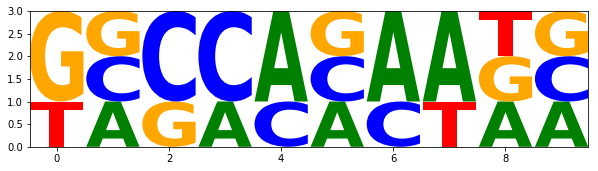

In [18]:
lm.Logo(counts_mat)